# 🧠 Mineral Prospectivity Mapping with AI/ML
This notebook demonstrates how to apply machine learning for mineral exploration using geoscientific datasets.

In [1]:
# 📦 Install required packages
#!pip install geopandas rasterio scikit-learn xgboost pandas matplotlib

In [1]:
# 📚 Import libraries
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
data.columns

Index(['FID', 'Shape *', 'gid', 'objectid', 'sampleno', 'X', 'Y', 'Si02_%',
       'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%',
       'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm', 'Ga_ppm', 'Sc_ppm', 'V_ppm',
       'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm', 'Rb_ppm', 'Sr_ppm', 'Y_ppm',
       'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm', 'Zn_ppm', 'Au_ppb', 'Li_ppm',
       'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm', 'Se_ppm', 'Ag_ppb', 'Cd_ppb',
       'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm', 'Sn_ppm', 'La_ppm', 'Ce_ppm',
       'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm', 'Tb_ppm', 'Gd_ppm', 'Dy_ppm',
       'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm', 'Lu_ppm', 'Hf_ppm', 'Ta_ppm',
       'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb', 'In_ppm', 'F_ppm', 'Te_ppm',
       'Tl_ppm', 'toposheet'],
      dtype='object')

In [3]:
data.drop(columns=['FID', 'Shape *', 'gid', 'objectid', 'sampleno','toposheet'], inplace=True)

In [4]:
data_min= pd.DataFrame(data)
data_min

,X,Y,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,Na2O_%,...,Hf_ppm,Ta_ppm,W_ppm,U_ppm,Pt_ppb,Pd_ppb,In_ppm,F_ppm,Te_ppm,Tl_ppm
0,77.194444,15.599099,60.03,11.96,4.81,0.81,3.03,1.93,0.13,0.80,...,13.080,1.074,2.5,4.020,0.0,0.0,0.0,0.0,0.0,0.0
1,77.212963,15.599099,58.85,11.96,4.91,0.79,4.39,2.26,0.15,0.39,...,9.858,0.912,2.5,2.283,0.0,0.0,0.0,0.0,0.0,0.0
2,77.231481,15.599099,65.12,11.06,4.33,0.70,3.82,1.87,0.13,0.71,...,16.747,0.954,2.5,3.582,0.0,0.0,0.0,0.0,0.0,0.0
3,77.250000,15.599099,65.63,10.94,4.88,0.81,2.74,1.98,0.14,0.49,...,19.809,0.912,2.5,3.298,0.0,0.0,0.0,0.0,0.0,0.0
4,77.009259,15.617117,54.15,12.38,4.98,0.78,6.38,2.14,0.12,0.50,...,9.933,0.739,2.5,1.705,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,76.925900,13.994000,60.22,16.79,6.35,0.84,1.75,0.93,0.08,0.85,...,24.220,1.300,0.0,3.010,0.0,0.0,0.0,0.0,0.0,0.0
10000,76.944400,13.994000,61.65,14.65,5.64,0.66,2.80,1.18,0.08,1.21,...,23.110,0.970,0.0,2.820,0.0,0.0,0.0,0.0,0.0,0.0
10001,76.962900,13.994000,58.79,15.62,5.79,0.65,2.58,1.56,0.08,1.16,...,16.700,0.560,0.0,2.180,0.0,0.0,0.0,0.0,0.0,0.0
10002,76.981400,13.994000,62.18,15.70,5.52,0.88,2.29,1.05,0.08,2.06,...,21.430,0.680,0.0,2.270,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data_proper=pd.read_csv("./classificationofminerals/Physical_properties_rock_samples.csv")
data_proper['X']=data_proper['Longitude']
data_proper['Y']=data_proper['Latitude']
data_proper= data_proper[['X','Y','Density (g/cc)','Rock_type']]
float_cols = data_proper.select_dtypes(include=['float64']).columns
data_proper[float_cols] = data_proper[float_cols].astype('float32')
data_pro= pd.DataFrame(data_proper)
data_pro

,X,Y,Density (g/cc),Rock_type
0,76.010002,15.40,2.62,Pink Granite
1,76.110001,15.34,2.72,Hornblende
2,76.070000,15.26,2.56,Pegmatite
3,76.070000,15.28,3.05,Gabbro
4,76.019997,15.37,2.52,Pegmatite
...,...,...,...,...
359,77.570000,14.45,2.61,Sheared Granite
360,77.239998,14.33,2.59,Syeno Granite
361,77.089996,14.48,2.60,Tonalite
362,77.050003,14.27,2.59,Tonalite


In [6]:
import rasterio
import pandas as pd
import numpy as np

# Load the raster
with rasterio.open("./Magnetic/TAIL_TMI_GE.tiff") as src:
    band = src.read(1)  # Read the first band
    rows, cols = np.where(band != src.nodata)  # Skip nodata pixels
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    
    data = {
        "x": xs,
        "y": ys,
        "value": band[rows, cols]
    }

df1 = pd.DataFrame(data)
df1.to_csv("output.csv", index=False)
df1['X']=df1['x']
df1['Y']=df1['y']
data_magnet=df1[['X','Y', 'value']]
data_magnet

,X,Y,value
0,792975.0,1743187.5,43.202499
1,793012.5,1743187.5,44.842991
2,793050.0,1743187.5,47.101727
3,793087.5,1743187.5,49.853508
4,793125.0,1743187.5,52.735531
...,...,...,...
27519321,611325.0,1520325.0,-2.339118
27519322,611362.5,1520325.0,-6.987918
27519323,611400.0,1520325.0,-12.464251
27519324,611437.5,1520325.0,-17.452415


In [7]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

data_exploration = pd.read_csv("./exploration/coords.csv")


data_exploration.head()




# Step 2: Convert WKT geometry to shapely objects
data_exploration['geometry'] = data_exploration['geometry'].apply(wkt.loads)  # Assuming the column is named 'geometry'

# Step 3: Convert to GeoDataFrame
gdf_exploration = gpd.GeoDataFrame(data_exploration, geometry='geometry')

# Step 4: Get centroid (or bounding box center) as representative lat/lon
gdf_exploration['longitude'] = gdf_exploration.geometry.centroid.x
gdf_exploration['latitude'] = gdf_exploration.geometry.centroid.y

# Optional: Save updated file
gdf_exploration.to_csv('with_lat_lon.csv', index=False)

# Preview
print(gdf_exploration[['latitude', 'longitude','commodity']].head())



    latitude  longitude           commodity
0  15.750000  77.581816                Gold
1  14.779166  77.708334        Tin-Tungsten
2  15.000000  77.250000                Gold
3  14.500000  77.666666  Kimberlite,Diamond
4  14.370842  77.450004                Gold


In [8]:
data_exp=pd.read_csv('with_lat_lon.csv')
data_exp['X'] = data_exp['longitude']
data_exp['Y']= data_exp['latitude']
data_exp= data_exp[['X','Y','commodity']]
#float_cols = data_exp.select_dtypes(include=['float64']).columns
#data_exp[float_cols] = data_exp[float_cols].astype('float32')

In [9]:
data_lineaments=pd.read_csv("./classificationofminerals/lineament_Tectonics.csv")
data_lineaments.columns
data_lineaments['X']= data_lineaments['start_x']
data_lineaments['Y']= data_lineaments['start_y']
data_lineaments['shape_leng']= data_lineaments['SHAPE_LENG']
data_line=data_lineaments[['X','Y','CODE_DESC','shape_leng']]
float_cols = data_line.select_dtypes(include=['float64']).columns
data_line[float_cols] = data_line[float_cols].astype('float32')

C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\1604868545.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_line[float_cols] = data_line[float_cols].astype('float32')


In [10]:

import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./shear/shear_zone_25k_ngdr_20250224141143411.shp")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

df=gdf[['name','shape_leng','X','Y']] 
data_df= pd.DataFrame(df)
data_df

,name,shape_leng,X,Y
0,Shear fractures,508.173301,77.486741,14.760323
1,Shear fractures,508.173301,77.486227,14.762712
2,Shear fractures,508.173301,77.485904,14.764834
3,Shear zone,2618.273902,77.412662,15.661528
4,Shear zone,2618.273902,77.409426,15.665193
...,...,...,...,...
336,High strain zone with sinistral shear sense,26934.297076,76.133875,14.214042
337,High strain zone with sinistral shear sense,26934.297076,76.127022,14.224093
338,High strain zone with sinistral shear sense,26934.297076,76.120283,14.235971
339,High strain zone with sinistral shear sense,26934.297076,76.114115,14.245737


In [11]:
import geopandas as gpd
import os

input_folder = './fold'
output_folder = './fold'

for filename in os.listdir(input_folder):
    if filename.endswith('.shp'):
        shp_path = os.path.join(input_folder, filename)
        gdf = gpd.read_file(shp_path)

        # Optionally convert geometry to WKT string
        gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

        csv_filename = filename.replace('.shp', '.csv')
        csv_path = os.path.join(output_folder, csv_filename)
        gdf.to_csv(csv_path, index=False)

        print(f"Converted {filename} to {csv_filename}")


Converted fold_25k_ngdr_20250224140917945.shp to fold_25k_ngdr_20250224140917945.csv


C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\3300032022.py:13: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)


In [12]:

import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./fold")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

data_fold=gdf[['fold_type','shape_leng','X','Y']] 
data_fold

,fold_type,shape_leng,X,Y
0,Fold Axis (F2),11582.119756,76.159725,14.250030
1,Fold Axis (F2),11582.119756,76.158570,14.252582
2,Fold Axis (F2),11582.119756,76.157789,14.254447
3,Fold Axis (F2),11582.119756,76.156476,14.257569
4,Fold Axis (F2),11582.119756,76.154953,14.260977
...,...,...,...,...
723,Antiformal Fold Axis (F1),15577.775159,76.252817,14.137091
724,Antiformal Fold Axis (F1),15577.775159,76.252417,14.137234
725,Antiformal Fold Axis (F1),15577.775159,76.251246,14.137833
726,Antiformal Fold Axis (F1),15577.775159,76.250019,14.138633


In [13]:
import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./fault")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

data_fault=gdf[['X','Y','fault_type','shape_leng']]

In [14]:
data_gravity = pd.read_csv("./classificationofminerals/combined_NGPM_gravity.csv")
#data_gravity
data_gravity= data_gravity[['X','Y', 'bouguer_an']]
data_gr =pd.DataFrame(data_gravity)
data_gr

,X,Y,bouguer_an
0,76.8616,14.2522,-72
1,76.9966,14.2552,-68
2,76.9861,14.2556,-67
3,76.8458,14.2535,-72
4,76.9423,14.2554,-68
...,...,...,...
22811,76.7644,15.0312,-86
22812,76.7585,15.0224,-87
22813,76.7560,15.0133,-87
22814,76.8422,15.0198,-87


In [15]:
import geopandas as gpd
import geopandas as gpd
import os

# Path to folder with SHP files
folder_path = ".//classificationofminerals/geochronology"

# List all .shp files in the folder
shp_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".shp")]

# Read and
# Read and merge all SHP files into one GeoDataFrame
gdf_list = [gpd.read_file(shp) for shp in shp_files]
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

# Optional: print number of features and preview
print(f"Loaded {len(combined_gdf)} features from {len(shp_files)} shapefiles.")
combined_gdf=combined_gdf.fillna(0)

combined_gdf['X']=combined_gdf['latdd']
combined_gdf['Y']=combined_gdf['longdd']   
combined_gdf=combined_gdf[['X','Y','kar_','smnd_','upb_']]

Loaded 63 features from 4 shapefiles.


In [76]:
data1= pd.concat([data_min, data_pro], ignore_index=True)


In [16]:
data_min_pro= pd.merge(data_min, data_pro, on=['X','Y'], how="left")
data2= pd.merge(data_exp, data_line, on=['X','Y'], how="left" )
data3= pd.merge(data_min_pro, data_df, on=['X','Y'], how="left" )


In [17]:
data4= pd.merge(data3, data_fold,  on=['X','Y'], how="left")
data5= pd.merge(data2, data4,  on=['X','Y'], how="left")
data5 =data5.drop(columns=['shape_leng_x', 'shape_leng_y'])
data6=pd.merge(data5, data_fault,  on=['X','Y'], how="left")
data6

,X,Y,commodity,CODE_DESC,shape_leng_x,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,...,In_ppm,F_ppm,Te_ppm,Tl_ppm,Density (g/cc),Rock_type,name,fold_type,fault_type,shape_leng_y
0,77.581816,15.750000,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,77.708334,14.779166,Tin-Tungsten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,77.250000,15.000000,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,77.666666,14.500000,"Kimberlite,Diamond",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,77.450004,14.370842,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,77.583963,15.233655,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,76.586963,15.012046,Iron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,76.708367,13.791801,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,77.583124,15.233110,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data6 =data6.drop(columns=['shape_leng_x', 'shape_leng_y'])
data6

,X,Y,commodity,CODE_DESC,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,...,Pd_ppb,In_ppm,F_ppm,Te_ppm,Tl_ppm,Density (g/cc),Rock_type,name,fold_type,fault_type
0,77.581816,15.750000,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,77.708334,14.779166,Tin-Tungsten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,77.250000,15.000000,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,77.666666,14.500000,"Kimberlite,Diamond",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,77.450004,14.370842,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,77.583963,15.233655,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,76.586963,15.012046,Iron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,76.708367,13.791801,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,77.583124,15.233110,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
combined

,kar_,smnd_,upb_
0,83.0,0.0,0.0
1,87.0,0.0,0.0
2,97.0,0.0,0.0
3,98.0,0.0,0.0
4,101.0,0.0,0.0
...,...,...,...
58,0.0,0.0,164.0
59,0.0,0.0,165.0
60,0.0,0.0,166.0
61,0.0,0.0,169.0


In [20]:
data8=pd.merge(combined_gdf, data6,  on=['X','Y'], how="left") 


In [77]:
data2= pd.concat([data_exp, data_line], ignore_index=True )
data3= pd.concat([data1, data_df], ignore_index=True)
data4= pd.concat([data3, data_fold], ignore_index=True)
data5= pd.concat([data2, data4], ignore_index=True)
data6=pd.concat([data5, data_fault], ignore_index=True)
data8=pd.concat([data_gr, data6], ignore_index=True) 
data9=pd.concat([data8, combined], ignore_index=True)
#data_gravity

data9.to_csv("exploration_dataset.csv")

In [78]:
data9.to_csv("exploration_dataset.csv")

In [79]:
data7=pd.read_csv("exploration_dataset.csv")
data7.columns

C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\2120714917.py:1: DtypeWarning: Columns (4,5,73,74,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  data7=pd.read_csv("exploration_dataset.csv")


Index(['Unnamed: 0.1', 'X', 'Y', 'bouguer_an', 'commodity', 'CODE_DESC',
       'shape_leng', 'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%',
       'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm',
       'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm',
       'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm',
       'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm',
       'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm',
       'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm',
       'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm',
       'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb',
       'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm', 'Density (g/cc)', 'Rock_type',
       'name', 'fold_type', 'fault_type', 'Unnamed: 0', 'kar_', 'smnd_',
       'upb_'],
      dtype='object')

In [80]:
data7['X']=data7['X'].fillna(0)
data7['Y']=data7['Y'].fillna(0)
data7['commodity']=data7['commodity'].fillna('unknown')
data7['CODE_DESC']=data7['CODE_DESC'].fillna('unknown')
data7['Density (g/cc)']=data7['Density (g/cc)'].fillna(0)
data7['Rock_type']=data7['Rock_type'].fillna('unknown')
#data7['Susceptibility(X 10^(-6) CGS units)']=data7['Susceptibility(X 10^(-6) CGS units)'].fillna(0)
data7['fault_type']=data7['fault_type'].fillna('unknown')
data7['fold_type']=data7['fold_type'].fillna('unknown')
#data7['shape_leng']=data7['shape_leng'].fillna(0)
data7

,Unnamed: 0.1,X,Y,bouguer_an,commodity,CODE_DESC,shape_leng,Si02_%,Al2O3_%,Fe2O3_%,...,Tl_ppm,Density (g/cc),Rock_type,name,fold_type,fault_type,Unnamed: 0,kar_,smnd_,upb_
0,0,76.86160,14.25220,-72.0,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,0.0,unknown,NaN,unknown,unknown,NaN,NaN,NaN,NaN
1,1,76.99660,14.25520,-68.0,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,0.0,unknown,NaN,unknown,unknown,NaN,NaN,NaN,NaN
2,2,76.98610,14.25560,-67.0,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,0.0,unknown,NaN,unknown,unknown,NaN,NaN,NaN,NaN
3,3,76.84580,14.25350,-72.0,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,0.0,unknown,NaN,unknown,unknown,NaN,NaN,NaN,NaN
4,4,76.94230,14.25540,-68.0,unknown,unknown,NaN,NaN,NaN,NaN,...,NaN,0.0,unknown,NaN,unknown,unknown,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,34851,14.92056,76.80445,NaN,unknown,unknown,NaN,0.0,0.0,0.0,...,0.0,0.0,unknown,0.0,unknown,unknown,58.0,0.0,0.0,164.0
34852,34852,15.42083,76.93778,NaN,unknown,unknown,NaN,0.0,0.0,0.0,...,0.0,0.0,unknown,0.0,unknown,unknown,59.0,0.0,0.0,165.0
34853,34853,15.43750,76.90445,NaN,unknown,unknown,NaN,0.0,0.0,0.0,...,0.0,0.0,unknown,0.0,unknown,unknown,60.0,0.0,0.0,166.0
34854,34854,15.50417,77.02139,NaN,unknown,unknown,NaN,0.0,0.0,0.0,...,0.0,0.0,unknown,0.0,unknown,unknown,61.0,0.0,0.0,169.0


In [81]:
import pandas as pd
import numpy as np

# Step 1: Replace empty strings with NaN (handles blanks in CSV)
combined = data7.replace(r'^\s*$', np.nan, regex=True)

# Step 2: Try converting object columns that might be numeric
for col in combined.columns:
    if combined[col].dtype == 'object':
        try:
            combined[col] = pd.to_numeric(combined[col])
        except:
            pass  # Ignore columns that can't be converted

# Step 3: Now identify numeric columns
numeric_cols = combined.select_dtypes(include=['int64', 'float64']).columns

# Step 4: Fill NaNs in numeric columns with 0
combined[numeric_cols] = combined[numeric_cols].fillna(0)

# Optional: confirm it's filled
print(combined[numeric_cols].isna().sum())
combined.to_csv("exploration_dataset1.csv")
combined.columns

Unnamed: 0.1      0
X                 0
Y                 0
bouguer_an        0
shape_leng        0
                 ..
Density (g/cc)    0
Unnamed: 0        0
kar_              0
smnd_             0
upb_              0
Length: 75, dtype: int64


Index(['Unnamed: 0.1', 'X', 'Y', 'bouguer_an', 'commodity', 'CODE_DESC',
       'shape_leng', 'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%',
       'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm',
       'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm',
       'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm',
       'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm',
       'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm',
       'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm',
       'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm',
       'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb',
       'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm', 'Density (g/cc)', 'Rock_type',
       'name', 'fold_type', 'fault_type', 'Unnamed: 0', 'kar_', 'smnd_',
       'upb_'],
      dtype='object')

In [82]:
# 🗃️ Load exploration dataset
data = pd.read_csv("exploration_dataset1.csv")  # Replace with your actual dataset
features=['X', 'Y', 'commodity', 
       'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%',
       'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm', 'Ga_ppm', 'Sc_ppm',
       'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm', 'Rb_ppm', 'Sr_ppm',
       'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm', 'Zn_ppm', 'Au_ppb',
       'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm', 'Se_ppm', 'Ag_ppb',
       'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm', 'Sn_ppm', 'La_ppm',
       'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm', 'Tb_ppm', 'Gd_ppm',
       'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm', 'Lu_ppm', 'Hf_ppm',
       'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb', 'In_ppm', 'F_ppm',
       'Te_ppm', 'Tl_ppm', 'Density (g/cc)','commodity',
        'fault_type', 'fold_type', 'kar_', 'smnd_', 'upb_', 'Rock_type']
target=['kar_']
X = data[features]
Y = data[target]

C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\1479207903.py:2: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("exploration_dataset1.csv")  # Replace with your actual dataset


In [83]:
X = pd.get_dummies(X, columns=['fault_type', 'fold_type','commodity'], drop_first=True)
X

,X,Y,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,Na2O_%,...,commodity_Precious Stones,"commodity_Precious Stones,Lead,Zinc,Copper,Gold","commodity_Precious Stones,Zinc,Lead,Copper,Gold",commodity_Rare Earth Elements,"commodity_Rare Earth Elements,Rare Metals",commodity_Sulphides,"commodity_Sulphides,Gold,Iron",commodity_Tin-Tungsten,commodity_Tungsten,commodity_unknown
0,76.86160,14.25220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,76.99660,14.25520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,76.98610,14.25560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,76.84580,14.25350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,76.94230,14.25540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,14.92056,76.80445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
34852,15.42083,76.93778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
34853,15.43750,76.90445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
34854,15.50417,77.02139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Encode target and save the encoder
le_target = LabelEncoder()
Y_encoded = le_target.fit_transform(data['kar_'])

# Replace original Y
Y = Y_encoded



# Step 3: Identify and encode all categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # ensures all are numeric

# Step 4: Handle missing values
X = X.fillna(X.median(numeric_only=True))

# Step 5: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)

# Step 7: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 8: Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.2f}")
y_pred_labels = le_target.inverse_transform(y_pred)

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

label_encoders = {}  # store encoders

# Encode categorical columns and store encoders
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le  # save the encoder




✅ Accuracy: 1.00


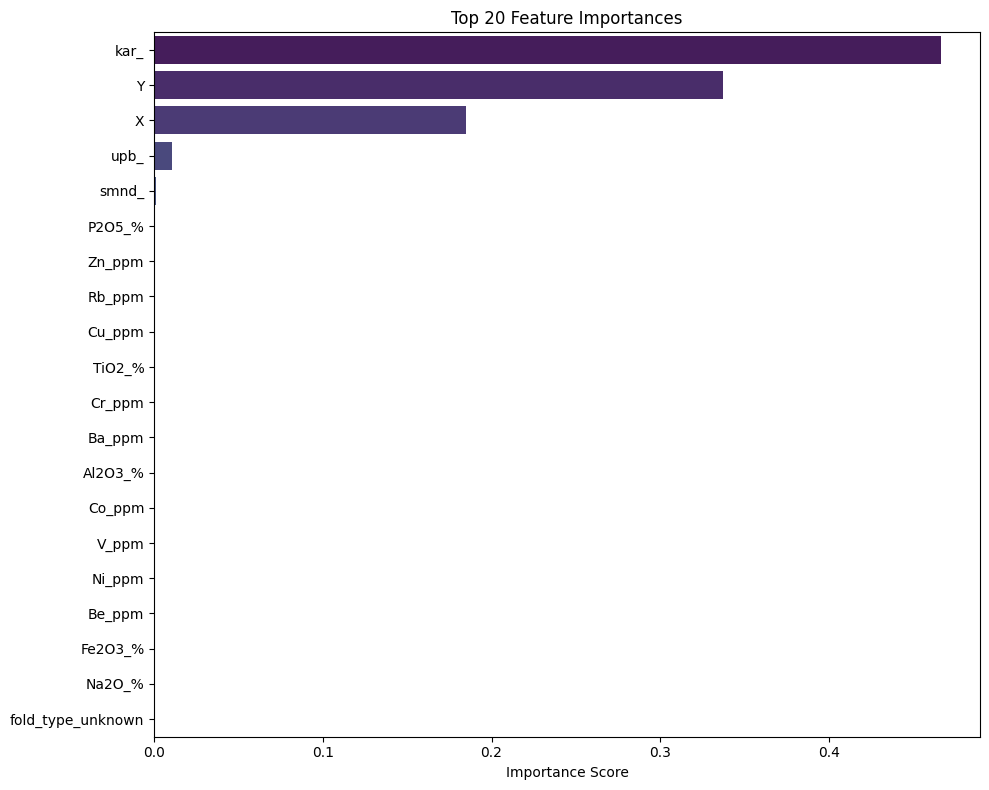

In [85]:

# Step 10: Feature Importance Plot
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20], palette='viridis')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

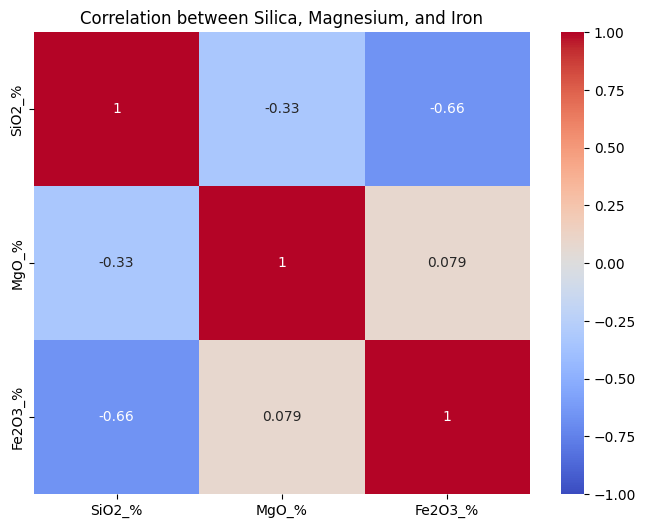

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
# Sample data (replace with your geochemical data)
data1 = {
    'SiO2_%': data['Si02_%'].values,
    'MgO_%': data['MgO_%'].values,
    'Fe2O3_%':data['Fe2O3_%'].values 
}

# Create a DataFrame
df = pd.DataFrame(data1)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Silica, Magnesium, and Iron')
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
data_proper=pd.read_csv("./classificationofminerals/Physical_properties_rock_samples.csv")


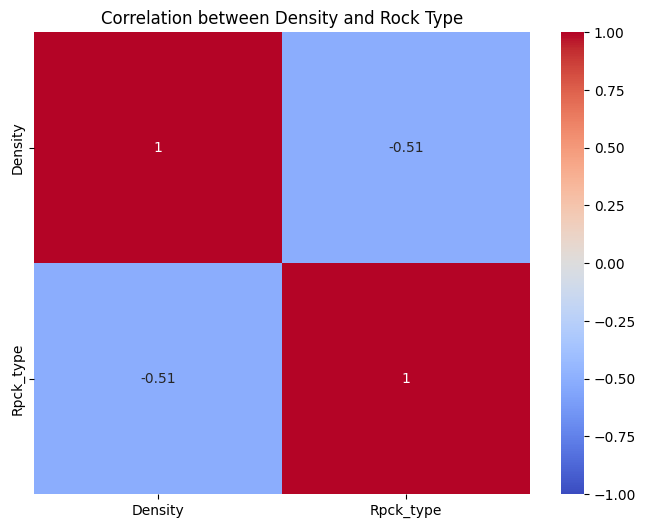

In [87]:

cat_cols = data_proper.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    data_proper['Rock_type'] = le.fit_transform(data_proper['Rock_type'].astype(str))
    label_encoders['Rock_type'] = le  # save the encoder


data1 = {
    'Density': data_proper['Density (g/cc)'].values,
    
    'Rpck_type':data_proper['Rock_type'].values 
}

# Create a DataFrame
df = pd.DataFrame(data1)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Density and Rock Type')
plt.show()


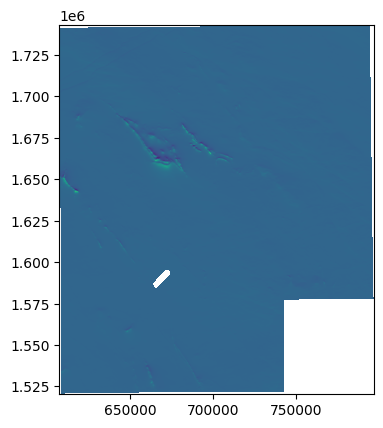

   gid input_cent  edition_no toposheet_ commodity descriptio accession_  \
0   77         SR           1      57B08    Copper       None       None   
1   80         SR           1      57E11   Diamond       None       None   
2   81         SR           1      57E11   Diamond       None       None   
3   82         SR           1      57E11   Diamond       None       None   
4   83         SR           1      57E11   Diamond       None       None   

  remarks                   geometry  
0    None   POINT (76.4441 14.14972)  
1    None  POINT (77.58692 15.28887)  
2    None  POINT (77.59776 15.29494)  
3    None  POINT (77.59186 15.28002)  
4    None  POINT (77.59679 15.28057)  


In [29]:
import rasterio
import geopandas as gpd
from rasterio.plot import show

raster = rasterio.open('./classificationofminerals/Magnet/TAIL_TMI_GE.tiff')
show(raster)
# Load shapefile
minerals = gpd.read_file('./classificationofminerals/Mineralization/mineralization_25k_ngdr_20250224141143411.shp')
print(minerals.head())


In [88]:
import geopandas as gpd
import os
import pandas as pd

# Path to folder with SHP files
folder_path = "./classificationofminerals/Mineralization"

# Read all SHP files
shp_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".shp")]
gdfs = [gpd.read_file(shp) for shp in shp_files]

# Combine into one GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

print(f"Loaded {len(combined_gdf)} features.")


Loaded 17 features.


In [89]:
import geopandas as gpd
import os
import pandas as pd

# Path to folder with SHP files
folder_path = "./classificationofminerals/geochronology"

# Read all SHP files
shp_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".shp")]
gdfs = [gpd.read_file(shp) for shp in shp_files]

# Combine into one GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

print(f"Loaded {len(combined_gdf)} features.")


Loaded 63 features.


In [92]:
comb= combined_gdf[['kar_','smnd_','upb_']]
comb= comb.fillna(0)
comb

,kar_,smnd_,upb_
0,83.0,0.0,0.0
1,87.0,0.0,0.0
2,97.0,0.0,0.0
3,98.0,0.0,0.0
4,101.0,0.0,0.0
...,...,...,...
58,0.0,0.0,164.0
59,0.0,0.0,165.0
60,0.0,0.0,166.0
61,0.0,0.0,169.0


In [93]:
# Convert to DataFrame without geometry
#df = combined_gdf.drop(columns="geometry")

# Optionally drop irrelevant fields (e.g., IDs)
df = comb.select_dtypes(include=["int", "float"])


In [94]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
combined_gdf["cluster"] = kmeans.fit_predict(df)


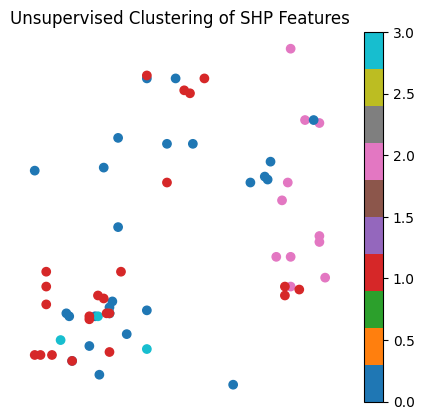

In [35]:
import matplotlib.pyplot as plt

combined_gdf.plot(column="cluster", cmap="tab10", legend=True)
plt.title("Unsupervised Clustering of SHP Features")
plt.axis("off")
plt.show()


In [95]:
# Drop rows without coordinates
df= pd.read_csv("exploration_dataset1.csv")
df.dropna(subset=["X", "Y",'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
df.columns
df=df[['X', 'Y',  'commodity',
       'CODE_DESC',  'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%',
       'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%',
       'Ba_ppm', 'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm',
       'Co_ppm', 'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm',
       'Cu_ppm', 'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm',
       'Bi_ppm', 'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm',
       'Mo_ppm', 'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm',
       'Eu_ppm', 'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm',
       'Yb_ppm', 'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb',
       'Pd_ppb', 'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm', 'Density (g/cc)',
       'Rock_type',  'name', 'fold_type',
       'fault_type', 'kar_', 'smnd_', 'upb_']]


C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\1257654034.py:2: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("exploration_dataset1.csv")


In [96]:
# Select features for clustering
feature_cols =['Si02_%','Al2O3_%','Fe2O3_%','TiO2_%','kar_','smnd_','upb_','Au_ppb']  # Replace with your real column names
features = df[feature_cols].select_dtypes(include=["int", "float"]).dropna()


In [97]:
features

,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,kar_,smnd_,upb_,Au_ppb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
34851,0.0,0.0,0.0,0.0,0.0,0.0,164.0,0.0
34852,0.0,0.0,0.0,0.0,0.0,0.0,165.0,0.0
34853,0.0,0.0,0.0,0.0,0.0,0.0,166.0,0.0
34854,0.0,0.0,0.0,0.0,0.0,0.0,169.0,0.0


In [98]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df["cluster"] = kmeans.fit_predict(features)


In [99]:
from sklearn.cluster import DBSCAN

coords = df[["Y", "X"]]
db = DBSCAN(eps=0.01, min_samples=5).fit(coords)
df["spatial_cluster"] = db.labels_


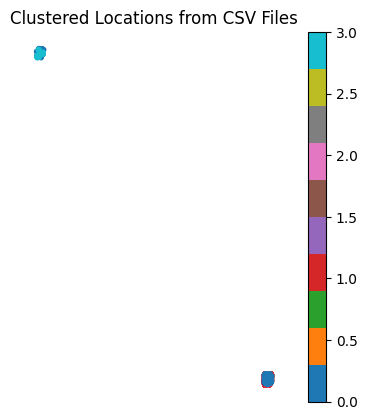

In [100]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create geometry column
df["geometry"] = df.apply(lambda row: Point(row["X"], row["Y"]), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Plot clusters
gdf.plot(column="cluster", cmap="tab10", legend=True, markersize=10)
plt.title("Clustered Locations from CSV Files")
plt.axis("off")
plt.show()


In [101]:
gdf.to_file("clustered_data.geojson", driver="GeoJSON")


In [102]:
gdf.to_file("clustered_data.shp")


C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\1684082401.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("clustered_data.shp")
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Density (g/cc)' to 'Density (g'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'spatial_cluster' to 'spatial_cl'
  ogr_write(


In [103]:
center_lon = df['X']
center_lat = df['Y']

df["distance_to_center"] = np.sqrt((df["X"] - center_lon)**2 + (df["Y"] - center_lat)**2)


In [104]:
df

,X,Y,commodity,CODE_DESC,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,...,name,fold_type,fault_type,kar_,smnd_,upb_,cluster,spatial_cluster,geometry,distance_to_center
0,76.86160,14.25220,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,unknown,unknown,0.0,0.0,0.0,0,1,POINT (76.86159992 14.25220013),0.0
1,76.99660,14.25520,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,unknown,unknown,0.0,0.0,0.0,0,-1,POINT (76.99660015 14.25519991),0.0
2,76.98610,14.25560,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,unknown,unknown,0.0,0.0,0.0,0,-1,POINT (76.9861002 14.25559998),0.0
3,76.84580,14.25350,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,unknown,unknown,0.0,0.0,0.0,0,-1,POINT (76.84579992 14.25349999),0.0
4,76.94230,14.25540,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,unknown,unknown,0.0,0.0,0.0,0,0,POINT (76.94229984 14.25540018),0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,14.92056,76.80445,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,unknown,unknown,0.0,0.0,164.0,3,-1,POINT (14.92056 76.80445),0.0
34852,15.42083,76.93778,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,unknown,unknown,0.0,0.0,165.0,3,-1,POINT (15.42083 76.93778),0.0
34853,15.43750,76.90445,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,unknown,unknown,0.0,0.0,166.0,3,-1,POINT (15.4375 76.90445),0.0
34854,15.50417,77.02139,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,unknown,unknown,0.0,0.0,169.0,3,-1,POINT (15.50417 77.02139),0.0


In [105]:
le.classes_ 


array(['Amphibolite', 'Applite', 'Banded  Gneiss/Tonalite Gneiss',
       'Banded Iron Formation', 'Biotite gneiss', 'Biotite granite',
       'Chlorite schist', 'Dolerite', 'Dolerite Dyke',
       'Dolerite Fine grained', 'Dolerite/mme', 'Dolertie',
       'Epidote granite', 'Foliated Granite', 'Gabbro', 'Granite',
       'Granite Gneiss', 'Granite gneiss', 'Granodiorite',
       'Granodiorite Gneiss', 'Grey Granite', 'Grey granite',
       'Hornblende', 'Hornblende Biotite Granite', 'Hornblende Granite',
       'Hornblendite', 'Leuco granite Gneiss', 'MME', 'Mafic Granite',
       'Meta Dolarite', 'Meta Gabbro', 'Metabasalt', 'Metarhyolite',
       'Migmatite', 'Pegmatite', 'Phyllite', 'Pink Granite',
       'Pink Porphyritic Granite', 'Pink granite', 'Porphyritic Granite',
       'Quartz Chlorite Schist', 'Quartz Epidote vein', 'Quartz vein',
       'Quartzite', 'Rhyolite', 'Schist', 'Sheared Granite',
       'Syeno Granite', 'TTG granite', 'Tonalite', 'Vein Quartz',
       'Weather

In [107]:
import numpy as np

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Earth radius in kilometers
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["distance_km"] = haversine(df["X"], df["Y"], center_lon, center_lat)


In [108]:
df.to_csv("engineered_features.csv", index=False)



# === ✅ Done ===
print("Feature engineering completed. Output saved.")

Feature engineering completed. Output saved.


In [109]:
df

,X,Y,commodity,CODE_DESC,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,...,fold_type,fault_type,kar_,smnd_,upb_,cluster,spatial_cluster,geometry,distance_to_center,distance_km
0,76.86160,14.25220,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,0.0,0,1,POINT (76.86159992 14.25220013),0.0,0.0
1,76.99660,14.25520,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,0.0,0,-1,POINT (76.99660015 14.25519991),0.0,0.0
2,76.98610,14.25560,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,0.0,0,-1,POINT (76.9861002 14.25559998),0.0,0.0
3,76.84580,14.25350,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,0.0,0,-1,POINT (76.84579992 14.25349999),0.0,0.0
4,76.94230,14.25540,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,0.0,0,0,POINT (76.94229984 14.25540018),0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,14.92056,76.80445,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,164.0,3,-1,POINT (14.92056 76.80445),0.0,0.0
34852,15.42083,76.93778,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,165.0,3,-1,POINT (15.42083 76.93778),0.0,0.0
34853,15.43750,76.90445,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,166.0,3,-1,POINT (15.4375 76.90445),0.0,0.0
34854,15.50417,77.02139,unknown,unknown,0.0,0.0,0.0,0.0,0.0,0.0,...,unknown,unknown,0.0,0.0,169.0,3,-1,POINT (15.50417 77.02139),0.0,0.0


In [110]:
features = df.select_dtypes(include=["int", "float"]).dropna()

In [111]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df["cluster"] = kmeans.fit_predict(features)


In [112]:
from sklearn.cluster import DBSCAN

coords = df[["Y", "X"]]
db = DBSCAN(eps=0.01, min_samples=5).fit(coords)
df["spatial_cluster"] = db.labels_

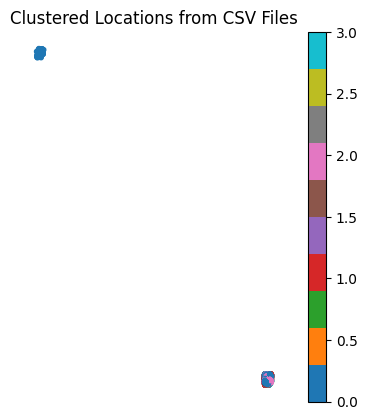

In [113]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create geometry column
df["geometry"] = df.apply(lambda row: Point(row["X"], row["Y"]), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Plot clusters
gdf.plot(column="cluster", cmap="tab10", legend=True, markersize=10)
plt.title("Clustered Locations from CSV Files")
plt.axis("off")
plt.show()

In [114]:
gdf.to_file("clustered_data.geojson", driver="GeoJSON")


In [115]:
gdf.to_file("clustered_data.shp")


C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\1684082401.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("clustered_data.shp")
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Density (g/cc)' to 'Density (g'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'spatial_cluster' to 'spatial_cl'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'distance_to_center' to 'distance_t'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'distance_km' to 'distance_k'
  ogr_write(


In [116]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. Read your CSV file
df = pd.read_csv("engineered_features.csv")  # Replace with your actual file name

# 2. Automatically find all object (categorical) columns
cat_columns = df.select_dtypes(include=['object']).columns

# 3. Initialize dictionary to store encoders for decoding later
encoders = {}

# 4. Encode each categorical column using LabelEncoder
for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure all values are strings
    encoders[col] = le  # Save encoder for future decoding

# Now df has all object columns converted to integers
print(df.head())


C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\3051105007.py:5: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("engineered_features.csv")  # Replace with your actual file name


         X        Y  commodity  CODE_DESC  Si02_%  Al2O3_%  Fe2O3_%  TiO2_%  \
0  76.8616  14.2522         52          2     0.0      0.0      0.0     0.0   
1  76.9966  14.2552         52          2     0.0      0.0      0.0     0.0   
2  76.9861  14.2556         52          2     0.0      0.0      0.0     0.0   
3  76.8458  14.2535         52          2     0.0      0.0      0.0     0.0   
4  76.9423  14.2554         52          2     0.0      0.0      0.0     0.0   

   CaO_%  MgO_%  ...  fold_type  fault_type  kar_  smnd_  upb_  cluster  \
0    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   
1    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   
2    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   
3    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   
4    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   

   spatial_cluster  geometry  distance_to_center  distance_km  
0         

In [117]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load feature data
#data = pd.read_csv("engineered_features.csv")

X = df.drop(columns=["commodity"]).values
y = df["commodity"].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # for regression; use output size = num_classes for classification_
 )

    def forward(self, x):
        return self.fc(x)

model = MLP(X_train.shape[1])
loss_fn = nn.MSELoss()  # or nn.CrossEntropyLoss() for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    pred = model(X_train).squeeze()
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

Epoch 0 - Loss: 2675.2744
Epoch 10 - Loss: 2577.6292
Epoch 20 - Loss: 2352.3540
Epoch 30 - Loss: 1887.4791
Epoch 40 - Loss: 1210.8937
Epoch 50 - Loss: 617.1039
Epoch 60 - Loss: 211.8599
Epoch 70 - Loss: 91.5940
Epoch 80 - Loss: 105.1215
Epoch 90 - Loss: 77.3893


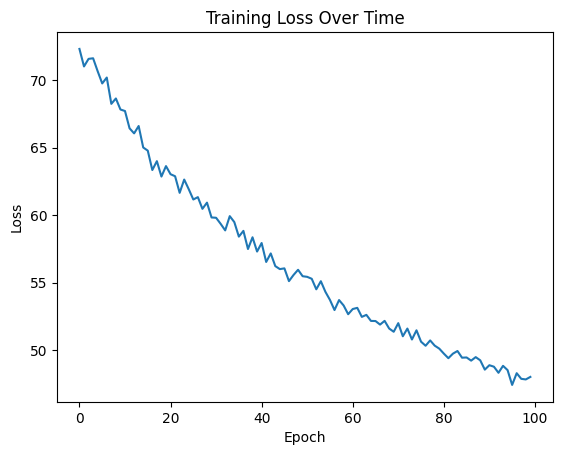

In [118]:
losses = []
for epoch in range(100):
    pred = model(X_train).squeeze()
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()


In [119]:
# 🔁 Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib

# 📥 Load Data
df = pd.read_csv("engineered_features.csv")
cat_columns = df.select_dtypes(include=['object']).columns

# 3. Initialize dictionary to store encoders for decoding later
encoders = {}

# 4. Encode each categorical column using LabelEncoder
for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Ensure all values are strings
    encoders[col] = le  # Save encoder for future decoding

# Now df has all object columns converted to integers
print(df.head())


# ✨ Features & Target
features = ["fold_type", "fault_type", 'Si02_%',
       'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%',
       'K2O_%', 'P2O5_%']
X = df[features].values
y = df["commodity"]

# 🎯 Encode Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

# 💾 Save encoder
joblib.dump(le, "label_encoder.pkl")

# ✂️ Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 🧠 Convert to Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# ⚙️ Dataset & Dataloader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 🧠 Define Model
class MineralClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

model = MineralClassifier(input_size=12, num_classes=num_classes)

# 🧮 Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\2618113201.py:12: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("engineered_features.csv")


         X        Y  commodity  CODE_DESC  Si02_%  Al2O3_%  Fe2O3_%  TiO2_%  \
0  76.8616  14.2522         52          2     0.0      0.0      0.0     0.0   
1  76.9966  14.2552         52          2     0.0      0.0      0.0     0.0   
2  76.9861  14.2556         52          2     0.0      0.0      0.0     0.0   
3  76.8458  14.2535         52          2     0.0      0.0      0.0     0.0   
4  76.9423  14.2554         52          2     0.0      0.0      0.0     0.0   

   CaO_%  MgO_%  ...  fold_type  fault_type  kar_  smnd_  upb_  cluster  \
0    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   
1    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   
2    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   
3    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   
4    0.0    0.0  ...          5           3   0.0    0.0   0.0        0   

   spatial_cluster  geometry  distance_to_center  distance_km  
0         

In [120]:
# 🔁 Training Loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

Epoch 1 - Loss: 102.8358
Epoch 2 - Loss: 33.4286
Epoch 3 - Loss: 33.1514
Epoch 4 - Loss: 32.7139
Epoch 5 - Loss: 32.7008
Epoch 6 - Loss: 32.8822
Epoch 7 - Loss: 32.5817
Epoch 8 - Loss: 32.4197
Epoch 9 - Loss: 32.3866
Epoch 10 - Loss: 32.1433
Epoch 11 - Loss: 32.3573
Epoch 12 - Loss: 32.2358
Epoch 13 - Loss: 32.2858
Epoch 14 - Loss: 32.3341
Epoch 15 - Loss: 31.9406
Epoch 16 - Loss: 32.0809
Epoch 17 - Loss: 32.1683
Epoch 18 - Loss: 32.0732
Epoch 19 - Loss: 31.6475
Epoch 20 - Loss: 31.9972
Epoch 21 - Loss: 31.7252
Epoch 22 - Loss: 32.0656
Epoch 23 - Loss: 31.6895
Epoch 24 - Loss: 31.7077
Epoch 25 - Loss: 31.7069
Epoch 26 - Loss: 31.7096
Epoch 27 - Loss: 31.5627
Epoch 28 - Loss: 31.4476
Epoch 29 - Loss: 31.4060
Epoch 30 - Loss: 31.4224


In [121]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
# 📊 Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_labels = torch.argmax(y_pred, dim=1).numpy()

    unique_labels = np.unique(y_test)
    target_names = le.inverse_transform(unique_labels)

# Make sure target_names is always a list
    if isinstance(target_names, str):
       target_names = [target_names]

       print(classification_report(
           y_test,
           y_pred_labels,
           labels=unique_labels,
           target_names=target_names
))


# 🔮 Predict on Full Dataset
X_tensor = torch.tensor(df[features].values, dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_tensor)
    predicted_indices = torch.argmax(predictions, dim=1).numpy()
    predicted_labels = le.inverse_transform(predicted_indices)
    
# 📤 Save Predictions
df["predicted_mineral"] = predicted_labels
df[["X", "Y", "predicted_mineral"]].to_csv("predictions.csv", index=False)
print("✅ predictions.csv saved.")

✅ predictions.csv saved.


In [122]:
df

,X,Y,commodity,CODE_DESC,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,...,fault_type,kar_,smnd_,upb_,cluster,spatial_cluster,geometry,distance_to_center,distance_km,predicted_mineral
0,76.86160,14.25220,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,0.0,0,1,14908,0.0,0.0,52
1,76.99660,14.25520,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,0.0,0,-1,16969,0.0,0.0,52
2,76.98610,14.25560,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,0.0,0,-1,16877,0.0,0.0,52
3,76.84580,14.25350,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,0.0,0,-1,14633,0.0,0.0,52
4,76.94230,14.25540,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,0.0,0,0,16123,0.0,0.0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,14.92056,76.80445,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,164.0,3,-1,41,0.0,0.0,52
34852,15.42083,76.93778,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,165.0,3,-1,55,0.0,0.0,52
34853,15.43750,76.90445,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,166.0,3,-1,56,0.0,0.0,52
34854,15.50417,77.02139,52,2,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0.0,0.0,169.0,3,-1,57,0.0,0.0,52


In [127]:
df=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")

In [128]:
df

,FID,Shape *,gid,objectid,sampleno,X,Y,Si02_%,Al2O3_%,Fe2O3_%,...,Ta_ppm,W_ppm,U_ppm,Pt_ppb,Pd_ppb,In_ppm,F_ppm,Te_ppm,Tl_ppm,toposheet
0,0,Point,129,129,57E02/081/SS/00,77.194444,15.599099,60.03,11.96,4.81,...,1.074,2.5,4.020,0.0,0.0,0.0,0.0,0.0,0.0,57E02
1,1,Point,130,130,57E02/082/SS/00,77.212963,15.599099,58.85,11.96,4.91,...,0.912,2.5,2.283,0.0,0.0,0.0,0.0,0.0,0.0,57E02
2,2,Point,131,131,57E02/083/SS/00,77.231481,15.599099,65.12,11.06,4.33,...,0.954,2.5,3.582,0.0,0.0,0.0,0.0,0.0,0.0,57E02
3,3,Point,132,132,57E02/084/SS/00,77.250000,15.599099,65.63,10.94,4.88,...,0.912,2.5,3.298,0.0,0.0,0.0,0.0,0.0,0.0,57E02
4,4,Point,133,133,57E02/085/SS/00,77.009259,15.617117,54.15,12.38,4.98,...,0.739,2.5,1.705,0.0,0.0,0.0,0.0,0.0,0.0,57E02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,9999,Point,279183,279365,57C13/192/S/17-18,76.925900,13.994000,60.22,16.79,6.35,...,1.300,0.0,3.010,0.0,0.0,0.0,0.0,0.0,0.0,57C13
10000,10000,Point,279184,279366,57C13/193/S/17-18,76.944400,13.994000,61.65,14.65,5.64,...,0.970,0.0,2.820,0.0,0.0,0.0,0.0,0.0,0.0,57C13
10001,10001,Point,279185,279367,57C13/194/S/17-18,76.962900,13.994000,58.79,15.62,5.79,...,0.560,0.0,2.180,0.0,0.0,0.0,0.0,0.0,0.0,57C13
10002,10002,Point,279186,279368,57C13/195/S/17-18,76.981400,13.994000,62.18,15.70,5.52,...,0.680,0.0,2.270,0.0,0.0,0.0,0.0,0.0,0.0,57C13


In [129]:
df.drop(columns=['FID', 'Shape *', 'gid', 'objectid', 'sampleno','toposheet'], inplace=True)

In [130]:
df

,X,Y,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,Na2O_%,...,Hf_ppm,Ta_ppm,W_ppm,U_ppm,Pt_ppb,Pd_ppb,In_ppm,F_ppm,Te_ppm,Tl_ppm
0,77.194444,15.599099,60.03,11.96,4.81,0.81,3.03,1.93,0.13,0.80,...,13.080,1.074,2.5,4.020,0.0,0.0,0.0,0.0,0.0,0.0
1,77.212963,15.599099,58.85,11.96,4.91,0.79,4.39,2.26,0.15,0.39,...,9.858,0.912,2.5,2.283,0.0,0.0,0.0,0.0,0.0,0.0
2,77.231481,15.599099,65.12,11.06,4.33,0.70,3.82,1.87,0.13,0.71,...,16.747,0.954,2.5,3.582,0.0,0.0,0.0,0.0,0.0,0.0
3,77.250000,15.599099,65.63,10.94,4.88,0.81,2.74,1.98,0.14,0.49,...,19.809,0.912,2.5,3.298,0.0,0.0,0.0,0.0,0.0,0.0
4,77.009259,15.617117,54.15,12.38,4.98,0.78,6.38,2.14,0.12,0.50,...,9.933,0.739,2.5,1.705,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,76.925900,13.994000,60.22,16.79,6.35,0.84,1.75,0.93,0.08,0.85,...,24.220,1.300,0.0,3.010,0.0,0.0,0.0,0.0,0.0,0.0
10000,76.944400,13.994000,61.65,14.65,5.64,0.66,2.80,1.18,0.08,1.21,...,23.110,0.970,0.0,2.820,0.0,0.0,0.0,0.0,0.0,0.0
10001,76.962900,13.994000,58.79,15.62,5.79,0.65,2.58,1.56,0.08,1.16,...,16.700,0.560,0.0,2.180,0.0,0.0,0.0,0.0,0.0,0.0
10002,76.981400,13.994000,62.18,15.70,5.52,0.88,2.29,1.05,0.08,2.06,...,21.430,0.680,0.0,2.270,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

data_exploration = pd.read_csv("./exploration/coords.csv")


data_exploration.head()




# Step 2: Convert WKT geometry to shapely objects
data_exploration['geometry'] = data_exploration['geometry'].apply(wkt.loads)  # Assuming the column is named 'geometry'

# Step 3: Convert to GeoDataFrame
gdf_exploration = gpd.GeoDataFrame(data_exploration, geometry='geometry')

# Step 4: Get centroid (or bounding box center) as representative lat/lon
gdf_exploration['longitude'] = gdf_exploration.geometry.centroid.x
gdf_exploration['latitude'] = gdf_exploration.geometry.centroid.y

# Optional: Save updated file
gdf_exploration.to_csv('with_lat_lon.csv', index=False)

# Preview
print(gdf_exploration[['latitude', 'longitude','commodity']].head())

In [131]:
gdf_exploration= gdf_exploration[['latitude', 'longitude','commodity']]
gdf_exploration['X'] = gdf_exploration['longitude']
gdf_exploration['Y']=gdf_exploration['latitude']
gdf_exploration=gdf_exploration[['X','Y', 'commodity']]

In [132]:
data_gravity = pd.read_csv("./classificationofminerals/combined_NGPM_gravity.csv")
#data_gravity
data_gravity= data_gravity[['X','Y', 'bouguer_an']]
data_gr =pd.DataFrame(data_gravity)
data_gr

,X,Y,bouguer_an
0,76.8616,14.2522,-72
1,76.9966,14.2552,-68
2,76.9861,14.2556,-67
3,76.8458,14.2535,-72
4,76.9423,14.2554,-68
...,...,...,...
22811,76.7644,15.0312,-86
22812,76.7585,15.0224,-87
22813,76.7560,15.0133,-87
22814,76.8422,15.0198,-87


In [133]:
data_proper=pd.read_csv("./classificationofminerals/Physical_properties_rock_samples.csv")
data_proper['X']=data_proper['Longitude']
data_proper['Y']=data_proper['Latitude']
data_proper= data_proper[['X','Y','Density (g/cc)','Rock_type']]
float_cols = data_proper.select_dtypes(include=['float64']).columns
data_proper[float_cols] = data_proper[float_cols].astype('float32')
data_pro= pd.DataFrame(data_proper)
data_pro

,X,Y,Density (g/cc),Rock_type
0,76.010002,15.40,2.62,Pink Granite
1,76.110001,15.34,2.72,Hornblende
2,76.070000,15.26,2.56,Pegmatite
3,76.070000,15.28,3.05,Gabbro
4,76.019997,15.37,2.52,Pegmatite
...,...,...,...,...
359,77.570000,14.45,2.61,Sheared Granite
360,77.239998,14.33,2.59,Syeno Granite
361,77.089996,14.48,2.60,Tonalite
362,77.050003,14.27,2.59,Tonalite


In [136]:
import geopandas as gpd
import geopandas as gpd
import os

# Path to folder with SHP files
folder_path = ".//classificationofminerals/geochronology"

# List all .shp files in the folder
shp_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".shp")]

# Read and
# Read and merge all SHP files into one GeoDataFrame
gdf_list = [gpd.read_file(shp) for shp in shp_files]
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

# Optional: print number of features and preview
print(f"Loaded {len(combined_gdf)} features from {len(shp_files)} shapefiles.")
combined_gdf=combined_gdf.fillna(0)

combined_gdf['X']=combined_gdf['latdd']
combined_gdf['Y']=combined_gdf['longdd']   
combined_gdf=combined_gdf[['X','Y','kar_','smnd_','upb_']]

Loaded 63 features from 4 shapefiles.


In [137]:
data_lineament = pd.read_csv("./classificationofminerals/li_form.csv")
data_lineament['X']= data_lineament['start_x']
data_lineament['Y']= data_lineament['start_y']
data_li= data_lineament[['X','Y', 'LINEAMENT_']]
data_li

,X,Y,LINEAMENT_
0,77.658153,14.602673,Dyke
1,77.658886,14.586850,Joint/Fracture
2,77.664807,14.612671,Dyke
3,77.684270,14.579178,Dyke
4,77.685093,14.618871,Dyke
...,...,...,...
8742,77.449077,14.300391,Dyke
8743,77.472844,14.301515,Joint/Fracture
8744,77.448666,14.301466,Dyke
8745,77.441773,14.303509,Dyke


In [138]:
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString

# Load the shapefile
gdf_line = gpd.read_file("./classificationofminerals/lineaments/lineament_250k_ngdr.shp")

# Function to get first coordinate (start of the line)
def get_first_coord(geom):
    if isinstance(geom, LineString):
        return geom.coords[0]
    elif isinstance(geom, MultiLineString):
        first_line = list(geom.geoms)[0]
        return first_line.coords[0]
    else:
        return (None, None)

# Function to get last coordinate (end of the line)
def get_last_coord(geom):
    if isinstance(geom, LineString):
        return geom.coords[-1]
    elif isinstance(geom, MultiLineString):
        last_line = list(geom.geoms)[-1]
        return last_line.coords[-1]
    else:
        return (None, None)
# Extract start and end coordinates
gdf_line['start_x'] = gdf_line.geometry.apply(lambda g: get_first_coord(g)[0])
gdf_line['start_y'] = gdf_line.geometry.apply(lambda g: get_first_coord(g)[1])
gdf_line['end_x'] = gdf_line.geometry.apply(lambda g: get_last_coord(g)[0])
gdf_line['end_y'] = gdf_line.geometry.apply(lambda g: get_last_coord(g)[1])

# Optional: keep only relevant fields
columns_to_keep = ['start_x', 'start_y', 'end_x', 'end_y']
# Add more if your file has fields like 'Hole_ID', 'Depth', 'Grade'
columns_to_keep += [col for col in gdf_line.columns if col not in ['geometry']]

# Save to CSV
gdf_line[columns_to_keep].to_csv("./classificationofminerals/line.csv", index=False)
print("CSV saved as 'line.csv'")
data_liner=pd.read_csv("./classificationofminerals/line.csv")
data_liner['shape_leng']= data_liner['shape_len']
data_liner['X'] = data_liner['start_x']
data_liner['Y'] = data_liner['start_y']
data_liner= data_liner[['X','Y', 'l1descript', 'l2descript']]
float_cols = data_liner.select_dtypes(include=['float64']).columns
data_liner[float_cols] = data_liner[float_cols].astype('float32')
data_liner

CSV saved as 'line.csv'


,X,Y,l1descript,l2descript
0,76.521477,15.021110,Structural lineaments,Fault
1,76.547829,15.046881,Structural lineaments,Fault
2,76.484367,15.090077,Geomorphic Lineaments,Ridge parallel
3,76.528252,15.135104,Geomorphic Lineaments,Ridge parallel
4,76.716446,15.174648,Geomorphic Lineaments,Ridge parallel
...,...,...,...,...
866,76.389641,14.763165,Structural lineaments,Dyke
867,76.600327,14.778970,Structural lineaments,Dyke
868,76.363281,14.808835,Structural lineaments,Dyke
869,76.757141,14.862425,Structural lineaments,Dyke


In [149]:
df_gdf= pd.merge(gdf_exploration, df, on=['X','Y'], how="left")

In [150]:
gr_pro= pd.merge(data_gr, data_pro, on=['X','Y'], how="left")

In [151]:
comb_li =pd.merge(combined_gdf, data_li, on=['X','Y'], how="left")

In [152]:
df_comb= pd.merge(df_gdf, comb_li, on=['X','Y'], how="left")

In [153]:
df_pro=pd.merge(df_comb, gr_pro, on=['X','Y'], how="left")

In [154]:
df_pro

,X,Y,commodity,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,...,F_ppm,Te_ppm,Tl_ppm,kar_,smnd_,upb_,LINEAMENT_,bouguer_an,Density (g/cc),Rock_type
0,77.581816,15.750000,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,77.708334,14.779166,Tin-Tungsten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,77.250000,15.000000,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,77.666666,14.500000,"Kimberlite,Diamond",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,77.450004,14.370842,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,77.583963,15.233655,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,76.586963,15.012046,Iron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,76.708367,13.791801,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,77.583124,15.233110,Gold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
df_pro['Rock_type']=df_pro['Rock_type'].fillna('unknown')

In [156]:
import pandas as pd
import numpy as np

# Step 1: Replace empty strings with NaN (handles blanks in CSV)
co = df_pro.replace(r'^\s*$', np.nan, regex=True)

# Step 2: Try converting object columns that might be numeric
for col in co.columns:
    if co[col].dtype == 'object':
        try:
            co[col] = pd.to_numeric(co[col])
        except:
            pass  # Ignore columns that can't be converted

# Step 3: Now identify numeric columns
numeric_cols = co.select_dtypes(include=['int64', 'float64']).columns

# Step 4: Fill NaNs in numeric columns with 0
co[numeric_cols] = co[numeric_cols].fillna(0)

# Optional: confirm it's filled
print(co[numeric_cols].isna().sum())
co.to_csv("exp_dataset.csv")
co.columns

C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\2302184064.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  co = df_pro.replace(r'^\s*$', np.nan, regex=True)


X             0
Y             0
Si02_%        0
Al2O3_%       0
Fe2O3_%       0
             ..
kar_          0
smnd_         0
upb_          0
LINEAMENT_    0
bouguer_an    0
Length: 72, dtype: int64


Index(['X', 'Y', 'commodity', 'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%',
       'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%',
       'Ba_ppm', 'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm',
       'Co_ppm', 'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm',
       'Cu_ppm', 'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm',
       'Bi_ppm', 'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm',
       'Mo_ppm', 'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm',
       'Eu_ppm', 'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm',
       'Yb_ppm', 'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb',
       'Pd_ppb', 'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm', 'kar_', 'smnd_',
       'upb_', 'LINEAMENT_', 'bouguer_an', 'Density (g/cc)', 'Rock_type'],
      dtype='object')

In [159]:
co=co.fillna(0)
co

,X,Y,commodity,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,...,F_ppm,Te_ppm,Tl_ppm,kar_,smnd_,upb_,LINEAMENT_,bouguer_an,Density (g/cc),Rock_type
0,77.581816,15.750000,Gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1,77.708334,14.779166,Tin-Tungsten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
2,77.250000,15.000000,Gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
3,77.666666,14.500000,"Kimberlite,Diamond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
4,77.450004,14.370842,Gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,77.583963,15.233655,Gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
305,76.586963,15.012046,Iron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
306,76.708367,13.791801,Gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
307,77.583124,15.233110,Gold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown


In [161]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['Rock_type', 'commodity', 'LINEAMENT_']
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    co[col] = le.fit_transform(co[col].astype(str))
    encoders[col] = le


In [162]:
from sklearn.preprocessing import StandardScaler

num_cols = ['bouguer_an']
scaler = StandardScaler()
co[num_cols] = scaler.fit_transform(co[num_cols])


In [163]:
features = cat_cols + num_cols
target_col = 'commodity'

target_encoder = LabelEncoder()
co[target_col] = target_encoder.fit_transform(co[target_col])


In [164]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X = torch.tensor(co[features].values, dtype=torch.float32)
y = torch.tensor(co[target_col].values, dtype=torch.long)

dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [165]:
import torch.nn as nn

class MineralClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MineralClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = MineralClassifier(input_dim=X.shape[1], num_classes=len(target_encoder.classes_))


In [166]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


Epoch 1 Loss: 3.6291
Epoch 2 Loss: 3.5557
Epoch 3 Loss: 3.4190
Epoch 4 Loss: 3.2448
Epoch 5 Loss: 3.2044
Epoch 6 Loss: 3.2391
Epoch 7 Loss: 3.3056
Epoch 8 Loss: 3.3053
Epoch 9 Loss: 3.4956
Epoch 10 Loss: 3.1781
Epoch 11 Loss: 2.9827
Epoch 12 Loss: 3.2067
Epoch 13 Loss: 3.6924
Epoch 14 Loss: 2.7808
Epoch 15 Loss: 3.2098
Epoch 16 Loss: 3.3559
Epoch 17 Loss: 3.0017
Epoch 18 Loss: 3.0721
Epoch 19 Loss: 3.4917
Epoch 20 Loss: 2.8983
Epoch 21 Loss: 3.0236
Epoch 22 Loss: 3.0445
Epoch 23 Loss: 2.8127
Epoch 24 Loss: 3.1362
Epoch 25 Loss: 2.7511
Epoch 26 Loss: 3.4977
Epoch 27 Loss: 2.7635
Epoch 28 Loss: 3.1583
Epoch 29 Loss: 3.0617
Epoch 30 Loss: 2.9461


In [171]:
model.eval()
with torch.no_grad():
    preds = model(X)
    pred_classes = torch.argmax(preds, dim=1).numpy()

# Decode back to mineral names
co['predicted_mineral'] = target_encoder.inverse_transform(pred_classes)


In [169]:
!pip install folium


   ---------------------------------------- 0.0/112.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/112.5 kB ? eta -:--:--
   --- ------------------------------------ 10.2/112.5 kB ? eta -:--:--
   --- ------------------------------------ 10.2/112.5 kB ? eta -:--:--
   --- ------------------------------------ 10.2/112.5 kB ? eta -:--:--
   -------------- ------------------------ 41.0/112.5 kB 178.6 kB/s eta 0:00:01
   --------------------- ----------------- 61.4/112.5 kB 233.8 kB/s eta 0:00:01
   ------------------------ -------------- 71.7/112.5 kB 231.0 kB/s eta 0:00:01
   ------------------------------- ------- 92.2/112.5 kB 275.8 kB/s eta 0:00:01
   ---------------------------------- --- 102.4/112.5 kB 280.1 kB/s eta 0:00:01
   ---------------------------------- --- 102.4/112.5 kB 280.1 kB/s eta 0:00:01
   -------------------------------------- 112.5/112.5 kB 233.4 kB/s eta 0:00:00


In [173]:
import folium

m = folium.Map(location=[co['Y'].mean(), co['X'].mean()], zoom_start=6)

for _, row in co.iterrows():
    folium.Marker(
        location=[row['Y'], row['X']],
        popup=row['predicted_mineral']
    ).add_to(m)

m.save("mineral_prediction_map.html")


In [174]:

from IPython.display import IFrame
IFrame("mineral_prediction_map.html", width=700, height=500)


In [176]:
import folium
import random

# Get all unique minerals
unique_minerals = co['predicted_mineral'].unique()

# Define a list of colors (add more if needed)
colors = [
    "red", "blue", "green", "purple", "orange", "darkred", "lightred", "beige",
    "darkblue", "darkgreen", "cadetblue", "darkpurple", "white", "pink", "lightblue",
    "lightgreen", "gray", "black", "lightgray"
]

# Assign a color to each mineral
mineral_color_map = {
    mineral: colors[i % len(colors)] for i, mineral in enumerate(unique_minerals)
}


In [177]:
# Center the map
m = folium.Map(location=[co['Y'].mean(), co['X'].mean()], zoom_start=6)

# Add color-coded markers
for _, row in co.iterrows():
    mineral = row['predicted_mineral']
    color = mineral_color_map.get(mineral, "gray")  # default to gray if missing

    folium.CircleMarker(
        location=[row['Y'], row['X']],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=f"Mineral: {mineral}"
    ).add_to(m)

# Save the map
m.save("mineral_prediction_map.html")


In [178]:
from IPython.display import IFrame
IFrame("mineral_prediction_map.html", width=700, height=500)


In [181]:
features = cat_cols + num_cols
target_col = 'Au_ppb'

target_encoder = LabelEncoder()
co[target_col] = target_encoder.fit_transform(co[target_col])


In [182]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X = torch.tensor(co[features].values, dtype=torch.float32)
y = torch.tensor(co[target_col].values, dtype=torch.long)

dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [183]:
import torch.nn as nn

class MineralClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MineralClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = MineralClassifier(input_dim=X.shape[1], num_classes=len(target_encoder.classes_))

In [184]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


Epoch 1 Loss: 0.0000
Epoch 2 Loss: 0.0000
Epoch 3 Loss: 0.0000
Epoch 4 Loss: 0.0000
Epoch 5 Loss: 0.0000
Epoch 6 Loss: 0.0000
Epoch 7 Loss: 0.0000
Epoch 8 Loss: 0.0000
Epoch 9 Loss: 0.0000
Epoch 10 Loss: 0.0000
Epoch 11 Loss: 0.0000
Epoch 12 Loss: 0.0000
Epoch 13 Loss: 0.0000
Epoch 14 Loss: 0.0000
Epoch 15 Loss: 0.0000
Epoch 16 Loss: 0.0000
Epoch 17 Loss: 0.0000
Epoch 18 Loss: 0.0000
Epoch 19 Loss: 0.0000
Epoch 20 Loss: 0.0000
Epoch 21 Loss: 0.0000
Epoch 22 Loss: 0.0000
Epoch 23 Loss: 0.0000
Epoch 24 Loss: 0.0000
Epoch 25 Loss: 0.0000
Epoch 26 Loss: 0.0000
Epoch 27 Loss: 0.0000
Epoch 28 Loss: 0.0000
Epoch 29 Loss: 0.0000
Epoch 30 Loss: 0.0000


In [185]:
model.eval()
with torch.no_grad():
    preds = model(X)
    pred_classes = torch.argmax(preds, dim=1).numpy()

# Decode back to mineral names
co['Gold_mineral'] = target_encoder.inverse_transform(pred_classes)


In [187]:
import folium

m = folium.Map(location=[co['Y'].mean(), co['X'].mean()], zoom_start=6)

for _, row in co.iterrows():
    folium.Marker(
        location=[row['Y'], row['X']],
        popup=row['Gold_mineral']
    ).add_to(m)

m.save("mineral1_prediction_map.html")


In [188]:
# Center the map
m = folium.Map(location=[co['Y'].mean(), co['X'].mean()], zoom_start=6)

# Add color-coded markers
for _, row in co.iterrows():
    mineral = row['Gold_mineral']
    color = mineral_color_map.get(mineral, "gray")  # default to gray if missing

    folium.CircleMarker(
        location=[row['Y'], row['X']],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=f"Mineral: {mineral}"
    ).add_to(m)

# Save the map
m.save("mineral1_prediction_map.html")


In [189]:
from IPython.display import IFrame
IFrame("mineral1_prediction_map.html", width=700, height=500)


In [190]:
import pandas as pd
data_rock1= pd.read_csv('./classificationofminerals/rock_types/all_tiff_dose.csv')
data_rock1['X']= data_rock1['X']/10000
data_rock1['Y']= data_rock1['Y']/100000
float_cols = data_rock1.select_dtypes(include=['float64']).columns
data_rock1[float_cols] = data_rock1[float_cols].astype('float32')
data_rock1

,X,Y,Value
0,79.214996,17.4321,13.232245
1,79.221001,17.4321,14.675505
2,79.226997,17.4321,16.155146
3,79.233002,17.4321,17.525503
4,79.238998,17.4321,18.655912
...,...,...,...
32249182,61.341000,15.2037,0.683738
32249183,61.347000,15.2037,0.677479
32249184,61.353001,15.2037,0.680494
32249185,61.359001,15.2037,0.693544


In [195]:
co

,X,Y,commodity,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,...,Tl_ppm,kar_,smnd_,upb_,LINEAMENT_,bouguer_an,Density (g/cc),Rock_type,predicted_mineral,Gold_mineral
0,77.581816,15.750000,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0
1,77.708334,14.779166,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0
2,77.250000,15.000000,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0
3,77.666666,14.500000,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0
4,77.450004,14.370842,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,77.583963,15.233655,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0
305,76.586963,15.012046,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0
306,76.708367,13.791801,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0
307,77.583124,15.233110,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0,16,0.0


In [192]:
import pandas as pd
data_rock2= pd.read_csv('./classificationofminerals/spectrometric/all_tiff_k_Th.csv')
data_rock2['X']= data_rock1['X']
data_rock2['Y']= data_rock1['Y']
float_cols = data_rock1.select_dtypes(include=['float64']).columns
data_rock2[float_cols] = data_rock1[float_cols].astype('float32')
data_rock2

,X,Y,Value
0,79.214996,17.4321,1.0
1,79.221001,17.4321,1.0
2,79.226997,17.4321,1.0
3,79.233002,17.4321,1.0
4,79.238998,17.4321,1.0
...,...,...,...
11739395,71.420998,17.2341,1.0
11739396,71.427002,17.2341,1.0
11739397,71.432999,17.2341,1.0
11739398,71.439003,17.2341,1.0


In [199]:
combine= pd.merge(data_rock1[:309], co, on=['X','Y'], how="left")
combine

,X,Y,Value,commodity,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,...,Tl_ppm,kar_,smnd_,upb_,LINEAMENT_,bouguer_an,Density (g/cc),Rock_type,predicted_mineral,Gold_mineral
0,79.214996,17.432100,13.232245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79.221001,17.432100,14.675505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,79.226997,17.432100,16.155146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,79.233002,17.432100,17.525503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,79.238998,17.432100,18.655912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,78.500999,17.430901,8.906657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,78.507004,17.430901,8.924905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,78.513000,17.430901,9.028368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,78.518997,17.430901,9.104091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
combine['Rock_type']=combine['Rock_type'].fillna('unknown')

In [203]:
combine['LINEAMENT_']=combine['LINEAMENT_'].fillna('unknown')
combine['commodity']=combine['commodity'].fillna('unknown')


In [204]:
combine=combine.drop(columns=['predicted_mineral','Gold_mineral'])

In [206]:
import numpy as np

# Step 1: Replace empty strings with NaN (handles blanks in CSV)
combine = combine.replace(r'^\s*$', np.nan, regex=True)

# Step 2: Try converting object columns that might be numeric
for col in combine.columns:
    if combine[col].dtype == 'object':
        try:
            combine[col] = pd.to_numeric(combine[col])
        except:
            pass  # Ignore columns that can't be converted

# Step 3: Now identify numeric columns
numeric_cols = combine.select_dtypes(include=['int64', 'float64']).columns

# Step 4: Fill NaNs in numeric columns with 0
combine[numeric_cols] = combine[numeric_cols].fillna(0)

# Optional: confirm it's filled
print(combine[numeric_cols].isna().sum())
combine.to_csv("exp_dataset1.csv")
combine.columns

commodity     0
Si02_%        0
Al2O3_%       0
Fe2O3_%       0
TiO2_%        0
             ..
smnd_         0
upb_          0
LINEAMENT_    0
bouguer_an    0
Rock_type     0
Length: 72, dtype: int64


Index(['X', 'Y', 'Value', 'commodity', 'Si02_%', 'Al2O3_%', 'Fe2O3_%',
       'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%', 'P2O5_%',
       'LOI_%', 'Ba_ppm', 'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm', 'Pb_ppm',
       'Ni_ppm', 'Co_ppm', 'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm', 'Nb_ppm',
       'Cr_ppm', 'Cu_ppm', 'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm', 'As_ppm',
       'Sb_ppm', 'Bi_ppm', 'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb', 'Be_ppm',
       'Ge_ppm', 'Mo_ppm', 'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm',
       'Sm_ppm', 'Eu_ppm', 'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm', 'Er_ppm',
       'Tm_ppm', 'Yb_ppm', 'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm', 'U_ppm',
       'Pt_ppb', 'Pd_ppb', 'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm', 'kar_',
       'smnd_', 'upb_', 'LINEAMENT_', 'bouguer_an', 'Density (g/cc)',
       'Rock_type'],
      dtype='object')

In [207]:
# Clean, encode, and normalize
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Example numeric + categorical features
features = ['bouguer_an',  'Value']
categorical = ['Rock_type', 'commodity','LINEAMENT_']

# Encode
for col in categorical:
    combine[col] = LabelEncoder().fit_transform(combine[col])

# Combine features
X_raw = combine[features + categorical]
X = StandardScaler().fit_transform(X_raw)


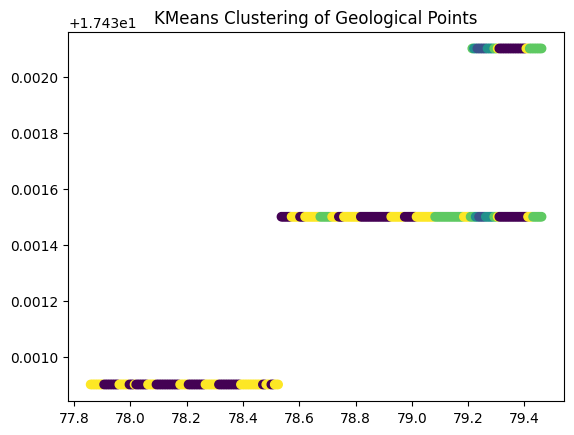

In [208]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=5, random_state=42)
combine['cluster'] = kmeans.fit_predict(X)

# Optional: visualize clusters
plt.scatter(combine['X'], combine['Y'], c=combine['cluster'], cmap='viridis')
plt.title("KMeans Clustering of Geological Points")
plt.show()


In [210]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Prepare tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(combine['commodity'].values, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define model
class GeoNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim)
        )
    def forward(self, x): return self.net(x)

model = GeoNet(in_dim=X_tensor.shape[1], out_dim=len(set(y_tensor.numpy())))


In [211]:
import folium

# Predict classes
model.eval()
with torch.no_grad():
    preds = model(X_tensor)
    pred_classes = torch.argmax(preds, axis=1).numpy()

combine['predicted_class'] = pred_classes

# Color mapping for prediction clusters
color_list = ['red', 'blue', 'green', 'purple', 'orange']
cluster_color = {i: color_list[i % len(color_list)] for i in combine['cluster'].unique()}

# Create map
m = folium.Map(location=[combine['Y'].mean(), combine['X'].mean()], zoom_start=6)

for _, row in combine.iterrows():
    folium.CircleMarker(
        location=[row['Y'], row['X']],
        radius=4,
        color=cluster_color[row['cluster']],
        fill=True,
        fill_opacity=0.8,
        popup=f"Cluster: {row['cluster']}, Pred: {row['predicted_class']}, Dose: {row['Value']}"
    ).add_to(m)

m.save("geo_model_cluster_map.html")


In [212]:
from IPython.display import IFrame
IFrame("geo_model_cluster_map.html", width=700, height=500)


In [224]:
df=pd.read_csv("engineered_features.csv")


C:\Users\ss529\AppData\Local\Temp\ipykernel_8384\2689935038.py:1: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("engineered_features.csv")


In [226]:

combine['fault_type'] = df['fault_type'][:309]
combine['fold_type'] = df['fold_type'][:309]

In [235]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


# Compute dose ratio from kar_ (K), upb_ (U), Th_ppm (Th)
combine['dose_ratio'] = (
    0.042 * combine['kar_'] + 
    0.367 * combine['upb_'] + 
    0.077 * combine['Th_ppm']
)

# Categorical features (optional)
categorical_cols = ['Rock_type', 'fault_type', 'fold_type']  # update if present
for col in categorical_cols:
    combine[col] = LabelEncoder().fit_transform(combine[col].astype(str))

# Target variable (e.g., mineral type)
combine['target'] = LabelEncoder().fit_transform(combine['commodity'])  # or another column

# Define features
features = ['kar_', 'upb_', 'Th_ppm', 'dose_ratio'] + categorical_cols
X = combine[features].values
y = combine['target'].values

# Standardize features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Use this instead:
X = combine[features]  # ← keep as DataFrame
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # no warning

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [236]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# Define model
class MineralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.model(x)

model = MineralNet(input_dim=X.shape[1], output_dim=len(np.unique(y)))


In [237]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")


Epoch 1 - Loss: 0.0000
Epoch 2 - Loss: 0.0000
Epoch 3 - Loss: 0.0000
Epoch 4 - Loss: 0.0000
Epoch 5 - Loss: 0.0000
Epoch 6 - Loss: 0.0000
Epoch 7 - Loss: 0.0000
Epoch 8 - Loss: 0.0000
Epoch 9 - Loss: 0.0000
Epoch 10 - Loss: 0.0000
Epoch 11 - Loss: 0.0000
Epoch 12 - Loss: 0.0000
Epoch 13 - Loss: 0.0000
Epoch 14 - Loss: 0.0000
Epoch 15 - Loss: 0.0000
Epoch 16 - Loss: 0.0000
Epoch 17 - Loss: 0.0000
Epoch 18 - Loss: 0.0000
Epoch 19 - Loss: 0.0000
Epoch 20 - Loss: 0.0000


In [238]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    pred_classes = torch.argmax(predictions, dim=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, pred_classes.numpy()))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62



In [239]:
df_scaled = scaler.transform(combine[features])
with torch.no_grad():
    full_preds = model(torch.tensor(df_scaled, dtype=torch.float32))
    combine['predicted_class'] = torch.argmax(full_preds, axis=1).numpy()

# Decode predicted label (if needed)
target_encoder = LabelEncoder()
combine['mineral_label'] = target_encoder.fit(combine['commodity']).inverse_transform(combine['predicted_class'])

import folium

m = folium.Map(location=[combine['Y'].mean(), combine['X'].mean()], zoom_start=6)

for _, row in combine.iterrows():
    folium.CircleMarker(
        location=[row['Y'], row['X']],
        radius=4,
        color='blue',
        fill=True,
        popup=f"Predicted: {row['mineral_label']}",
        fill_opacity=0.7
    ).add_to(m)

m.save("mineral2_prediction_map.html")


In [240]:
from IPython.display import IFrame
IFrame("mineral2_prediction_map.html", width=700, height=500)
